In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [2]:
# get the 4th root for embedding: https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

## The Preprocessed Data

In [3]:
# the combined forex and economic news data
df = pd.read_csv('fx_with_news.csv', header=[0,1], index_col=0)

In [4]:
df

c_eur                                           \
                         mean       std bar_len bar_spearman bar_log_r   
ctime                                                                    
2016-01-03 22:00:00  1.087467  0.000015    28.0    -0.737459 -0.000037   
2016-01-03 22:05:00  1.087362  0.000049   155.0    -0.181051 -0.000230   
2016-01-03 22:10:00  1.086980  0.000105   138.0    -0.460522 -0.000248   
2016-01-03 22:15:00  1.086938  0.000043   125.0     0.282268 -0.000028   
2016-01-03 22:20:00  1.087057  0.000148   115.0    -0.043127 -0.000120   
...                       ...       ...     ...          ...       ...   
2019-12-31 21:35:00  1.121460  0.000037    62.0    -0.800736 -0.000080   
2019-12-31 21:40:00  1.121460  0.000028    41.0    -0.141550 -0.000009   
2019-12-31 21:45:00  1.121388  0.000046   108.0     0.612689 -0.000018   
2019-12-31 21:50:00  1.121327  0.000046    97.0    -0.912678 -0.000143   
2019-12-31 21:55:00  1.121247  0.000131    91.0     0.075062  0.000294   

                                                                               \
                      first_r     max_r     min_r    last_r bar_quantile_25_r   
ctime                                                                           
2016-01-03 22:00:00  0.000030  0.000030 -0.000016 -0.000007         -0.000009   
2016-01-03 22:05:00  0.000081  0.000081 -0.000149 -0.000149         -0.000029   
2016-01-03 22:10:00  0.000203  0.000203 -0.000147 -0.000046         -0.000064   
2016-01-03 22:15:00 -0.000007  0.000057 -0.000108 -0.000035         -0.000007   
2016-01-03 22:20:00 -0.000144  0.000224 -0.000264 -0.000264         -0.000126   
...                       ...       ...       ...       ...               ...   
2019-12-31 21:35:00  0.000062  0.000062 -0.000036 -0.000018         -0.000027   
2019-12-31 21:40:00 -0.000027  0.000035 -0.000054 -0.000036         -0.000018   
2019-12-31 21:45:00  0.000029  0.000047 -0.000096  0.000011         -0.000025   
2019-12-31 21:50:00  0.000056  0.000092 -0.000122 -0.000086         -0.000015   
2019-12-31 21:55:00 -0.000033  0.000261 -0.000123  0.000261         -0.000078   

                     ...  \
                     ...   
ctime                ...   
2016-01-03 22:00:00  ...   
2016-01-03 22:05:00  ...   
2016-01-03 22:10:00  ...   
2016-01-03 22:15:00  ...   
2016-01-03 22:20:00  ...   
...                  ...   
2019-12-31 21:35:00  ...   
2019-12-31 21:40:00  ...   
2019-12-31 21:45:00  ...   
2019-12-31 21:50:00  ...   
2019-12-31 21:55:00  ...   

                                                             after_counter_ohe  \
                    _united states nondefense capital goods orders ex aircraft   
ctime                                                                            
2016-01-03 22:00:00                                           0.000000           
2016-01-03 22:05:00                                           0.000000           
2016-01-03 22:10:00                                           0.000000           
2016-01-03 22:15:00                                           0.000000           
2016-01-03 22:20:00                                           0.000000           
...                                                                ...           
2019-12-31 21:35:00                                           0.429514           
2019-12-31 21:40:00                                           0.429167           
2019-12-31 21:45:00                                           0.428819           
2019-12-31 21:50:00                                           0.428472           
2019-12-31 21:55:00                                           0.428125           

                                                     \
                    _united states nonfarm payrolls   
ctime                                                 
2016-01-03 22:00:00                             0.0   
2016-01-03 22:05:00                             0.0   
2016-01-03 22:10:00                

In [5]:
# list of currencies
c_list = ['c_eur', 'c_gbp', 'c_jpy']

In [6]:
# make new feature for more stable forecast
for cur in c_list:    
    # logreturn of the means
    df[(cur,'mean_log_r')] = np.log(1.0 + df[(cur,'mean')].pct_change())
    df[(cur,'mean_log_r')] = df[(cur,'mean_log_r')].fillna(0.0)

In [7]:
# column hierarchy
for top in list(df.columns.get_level_values(0).unique()):
    print('----------------------------------')
    print('TOP COLUMN: ', top)
    print('SUBCOLUMNS: ', len(df[top].columns))
    print(list(df[top].columns))


----------------------------------
TOP COLUMN:  c_eur
SUBCOLUMNS:  12
['mean', 'std', 'bar_len', 'bar_spearman', 'bar_log_r', 'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r', 'bar_quantile_75_r', 'mean_log_r']
----------------------------------
TOP COLUMN:  c_gbp
SUBCOLUMNS:  12
['mean', 'std', 'bar_len', 'bar_spearman', 'bar_log_r', 'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r', 'bar_quantile_75_r', 'mean_log_r']
----------------------------------
TOP COLUMN:  c_jpy
SUBCOLUMNS:  12
['mean', 'std', 'bar_len', 'bar_spearman', 'bar_log_r', 'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r', 'bar_quantile_75_r', 'mean_log_r']
----------------------------------
TOP COLUMN:  month
SUBCOLUMNS:  12
['_1', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12']
----------------------------------
TOP COLUMN:  dow
SUBCOLUMNS:  6
['_0', '_1', '_2', '_3', '_4', '_6']
----------------------------------
TOP COLUMN:  hour
SUBCOLUMNS:  24
['_0', '_1', '_2',

In [8]:
top_level = list(df.columns.get_level_values(0).unique())
top_level

['c_eur',
 'c_gbp',
 'c_jpy',
 'month',
 'dow',
 'hour',
 'event_cur',
 'event_exist',
 'actual_ohe',
 'surprise_ohe',
 'change_ohe',
 'after_counter_ohe']

## Processing for Model Input

In [9]:
# we will use 2016-2018 as training data, and 2019 as validation and test data
# problem: we have events that occure only in 2019
# we can't normalize/standardize/scale them based on 2016-2018 data
# we could move them to the '_(currency) event' columns, 
# but there is only a few, so here I will delete them

# have we all event type in 2016-2018 yers?
df['event_exist'].loc['2016':'2019'].any().all()

False

In [10]:
# find events occuring only in 2019
event_before_19 = df['event_exist'].loc['2016':'2019'].any()
event_only_19 = list(event_before_19[event_before_19==False].index)
event_only_19

['_european monetary union markit pmi composite',
 '_germany zew survey  economic sentiment',
 '_japan gross domestic product qoq',
 '_united states consumer price index ex food  energy mom',
 '_united states initial jobless claims 4week average',
 '_united states nondefense capital goods orders ex aircraft']

In [11]:
# drop events only occuring in 2019
df.drop(event_only_19, axis=1, level=1, inplace=True)

In [12]:
# have we all event type in 2016-2018 yers?
df['event_exist'].loc['2016':'2019'].any().all()
#ok

True

In [13]:
# rescaling output isn't always important, 
# but if the model has different output features it helps to weight their effect on the loss function
# or we can use multiple loss functions and manually set the weight
df_label = df.xs('mean', axis=1, level=1, drop_level=False)
df_label

,c_eur,c_gbp,c_jpy
,mean,mean,mean
ctime,,,
2016-01-03 22:00:00,1.087467,1.473700,0.831731
2016-01-03 22:05:00,1.087362,1.474204,0.831720
2016-01-03 22:10:00,1.086980,1.474567,0.831713
2016-01-03 22:15:00,1.086938,1.474208,0.831647
2016-01-03 22:20:00,1.087057,1.474157,0.831599
...,...,...,...
2019-12-31 21:35:00,1.121460,1.324929,0.920382
2019-12-31 21:40:00,1.121460,1.325454,0.920438


In [14]:
# we use only train and validation
# Standardizing and normalizing shifts the dataset, where +- sign can be important. Later the model will adjust this by the biases,
# but the information is lost. It could improve the performance if we make a new feature for + and - numbers, but here I don't want to make more features

In [15]:
# spearman doesn't need standardization
c_single_features = ['mean', 'std', 'bar_len']
feature_scalers = dict()

In [16]:
# standardize features based on data up to 2019-01-01 00:00
for cur in c_list:
    for feature in c_single_features:
        column_mean = df[cur, feature].loc['2016':'2019'].mean()
        column_std = df[cur, feature].loc['2016':'2019'].std()
        feature_scalers.update({(cur, feature) : [column_mean, column_std]})
        df.loc[:,(cur, feature)] = (df[cur, feature] - column_mean)/column_std

In [17]:
# !!! later we can use them to rescale if needed
feature_scalers # column_mean, column_std

{('c_eur', 'mean'): [1.1392483015708013, 0.04998154896157088],
 ('c_eur', 'std'): [0.00010543836669119064, 9.077071115943414e-05],
 ('c_eur', 'bar_len'): [412.9294628759021, 381.7685744752956],
 ('c_gbp', 'mean'): [1.3263368732176204, 0.06648514955410852],
 ('c_gbp', 'std'): [0.0001466428489918478, 0.0001589000772232711],
 ('c_gbp', 'bar_len'): [387.5186401063365, 303.3104183503984],
 ('c_jpy', 'mean'): [0.906695470940815, 0.033451362417663416],
 ('c_jpy', 'std'): [9.80057991353974e-05, 9.589094629696239e-05],
 ('c_jpy', 'bar_len'): [354.61210380295637, 299.81779856624456]}

In [18]:
c_related_features = ['mean_log_r','bar_log_r','first_r','max_r','min_r','last_r','bar_quantile_25_r','bar_quantile_75_r']
# these are related feature, we can think of them as one feature with subfeatures
# they are on similar scale 
# and the pairs on the other side of the mean (like max_r and min_r) are almost symmetric
# to preserve the signs we don't subtract the mean, only divide by the std
# this way we preserve their relative size
# *10000000 is only for easier comparison
print(df['c_eur'][c_related_features].abs().mean()*10000000)
print(df['c_eur'][c_related_features].mean()*10000000)

mean_log_r           1435.641469
bar_log_r            1756.307094
first_r              1079.158746
max_r                1680.077984
min_r                1686.788765
last_r                960.660734
bar_quantile_25_r     647.482120
bar_quantile_75_r     647.172621
dtype: float64
mean_log_r              1.023680
bar_log_r               8.380970
first_r                -0.840415
max_r                1680.077984
min_r               -1686.788765
last_r                  7.540555
bar_quantile_25_r    -647.041955
bar_quantile_75_r     646.659518
dtype: float64


In [19]:
related_std = df[cur, 'bar_log_r'].loc['2016':'2019'].std()

for cur in c_list:
    for feature in c_related_features:
        df.loc[:,(cur, feature)] = (df[cur, feature])/related_std

In [20]:
# !!! needed later to rescale outputs of log_r features
related_std

0.00035617512187632297

In [21]:
# ok, these features remained on similar scale, but the other features as well
print(df['c_eur'][c_related_features].abs().mean())
print(df['c_eur'][c_related_features].mean())

mean_log_r           0.403072
bar_log_r            0.493102
first_r              0.302985
max_r                0.471700
min_r                0.473584
last_r               0.269716
bar_quantile_25_r    0.181788
bar_quantile_75_r    0.181701
dtype: float64
mean_log_r           0.000287
bar_log_r            0.002353
first_r             -0.000236
max_r                0.471700
min_r               -0.473584
last_r               0.002117
bar_quantile_25_r   -0.181664
bar_quantile_75_r    0.181557
dtype: float64


In [22]:
df_label_return = df.xs('mean_log_r', axis=1, level=1, drop_level=False)
df_label_return

,c_eur,c_gbp,c_jpy
,mean_log_r,mean_log_r,mean_log_r
ctime,,,
2016-01-03 22:00:00,0.000000,0.000000,0.000000
2016-01-03 22:05:00,-0.271969,0.959393,-0.038811
2016-01-03 22:10:00,-0.986573,0.692598,-0.022978
2016-01-03 22:15:00,-0.108544,-0.684034,-0.222788
2016-01-03 22:20:00,0.306975,-0.096665,-0.160975
...,...,...,...
2019-12-31 21:35:00,-0.048386,0.197334,-0.022041
2019-12-31 21:40:00,-0.000601,1.112390,0.169539


In [23]:
# 'event_cur' is on similar scale, we don't touch (normalization would be better than standardization)
df['event_cur'].max()

_EUR    2.000000
_GBP    2.828427
_JPY    1.732051
_USD    3.000000
dtype: float64

In [24]:
# should consider every event type alone, but there are 76 event types, so just normalize
df['actual_ohe'] = (df['actual_ohe'] - df['actual_ohe'].loc['2016':'2019'].min())/(df['actual_ohe'].loc['2016':'2019'].max() - df['actual_ohe'].loc['2016':'2019'].min())
# where max-min == 0 we get NaN, fill with 0
df['actual_ohe'] = df['actual_ohe'].fillna(0.0)

In [25]:
# dividing with the max of absolute values keeps the signs
df['surprise_ohe'] = df['surprise_ohe']/df['surprise_ohe'].loc['2016':'2019'].abs().max()
df['surprise_ohe'] = df['surprise_ohe'].fillna(0.0)

df['change_ohe'] = df['change_ohe']/df['change_ohe'].loc['2016':'2019'].abs().max()
df['change_ohe'] = df['change_ohe'].fillna(0.0)

df['after_counter_ohe'] = df['after_counter_ohe']/df['after_counter_ohe'].loc['2016':'2019'].abs().max()
df['after_counter_ohe'] = df['after_counter_ohe'].fillna(0.0)

In [26]:
# df_label = df_label.astype('float16')
# df = df.astype('float16')
df_valid = df.loc['2019':]
df = df.loc[:'2019']
df_label_valid = df_label.loc['2019':]
df_label = df_label.loc[:'2019']
df_label_return_valid = df_label_return.loc['2019':]
df_label_return = df_label_return.loc[:'2019']

In [27]:
print(df.std().max())
print(df.std().mean())

1.1175694609369098
0.23388258061315467


In [28]:
df['after_counter_ohe'][df['after_counter_ohe']>0.0].count()

_eur event                                                 187122
_eur speech                                                126077
_european monetary union consumer price index  core yoy    148270
_european monetary union consumer price index yoy          148270
_european monetary union ecb deposit rate decision          63360
                                                            ...  
_united states reutersmichigan consumer sentiment index     60480
_united states trade balance                               103680
_united states unemployment rate                            74880
_usd event                                                 172408
_usd speech                                                208368
Length: 70, dtype: int64

In [29]:
# mean average error of no_price change
(df_label - df_label.shift()).abs().mean().mean()

0.0001977906033436539

In [30]:
# mean average error of no_return_change
# this data is scaled !!!, should multiply with related_std for real magnitude
(df_label_return - df_label_return.shift()).abs().mean().mean()

0.631797140944485

In [31]:
# the erro of the no_price_change forecast with returns:
# this data is scaled !!!, should multiply with related_std for real magnitude
df_label_return.abs().mean().mean()

0.49374693981256845

## The Datasets

In [32]:
train_size=144
shift=1
batch_size=64

In [33]:
# label data begins from the end of the first train data

def ds_input(df, concat_tops, feature_to_last):
    nx = df.to_numpy()
    if (isinstance(df.columns, pd.MultiIndex) and concat_tops==False):
        top_level_nb = len(df.columns.get_level_values(0).unique())
        sub_level_nb = len(df.columns.get_level_values(1).unique())
        nx = nx.reshape(-1,top_level_nb,sub_level_nb)
        if feature_to_last == True:
            nx = np.moveaxis(nx, [0,1,2], [0,2,1])
        nx = np.squeeze(nx)
    return nx

def make_ds(batch_size, time_steps, shift, skip_steps, df, concat_tops=False, feature_to_last=True):
    nx = ds_input(df, concat_tops, feature_to_last)
    ds = tf.data.Dataset.from_tensor_slices(nx[skip_steps:])
    ds = ds.window(time_steps, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(time_steps))
    return ds.batch(batch_size, drop_remainder=True)

In [54]:
label_dataset_args = {'batch_size':batch_size,
                      'time_steps':train_size,
                      'shift':shift, 
                      'skip_steps':1}

ds_label = make_ds(**label_dataset_args, df=df_label)
ds_label_valid = make_ds(**label_dataset_args, df=df_label_valid)

ds_label_return = make_ds(**label_dataset_args, df=df_label_return)
ds_label_return_valid = make_ds(**label_dataset_args, df=df_label_return_valid)

ds_label_return_eur = make_ds(**label_dataset_args, df=df_label_return['c_eur'])
ds_label_return_eur_valid = make_ds(**label_dataset_args, df=df_label_return_valid['c_eur'])

ds_label_return_gbp = make_ds(**label_dataset_args, df=df_label_return['c_gbp'])
ds_label_return_gbp_valid = make_ds(**label_dataset_args, df=df_label_return_valid['c_gbp'])

ds_label_return_jpy = make_ds(**label_dataset_args, df=df_label_return['c_jpy'])
ds_label_return_jpy_valid = make_ds(**label_dataset_args, df=df_label_return_valid['c_jpy'])

In [36]:
input_dataset_args = {'batch_size':batch_size,
                      'time_steps':train_size,
                      'shift':shift, 
                      'skip_steps':0}

ds_full = make_ds(**input_dataset_args, df=df, concat_tops=True)
ds_full_valid = make_ds(**input_dataset_args, df=df_valid, concat_tops=True)

ds_curbars = make_ds(**input_dataset_args, df=df[['c_eur', 'c_gbp', 'c_jpy']], concat_tops=True)
ds_curbars_valid = make_ds(**input_dataset_args, df=df_valid[['c_eur', 'c_gbp', 'c_jpy']], concat_tops=True)

ds_event_exist = make_ds(**input_dataset_args, df=df['event_exist'])
ds_event_exist_valid = make_ds(**input_dataset_args, df=df_valid['event_exist'])

ds_nosparse = make_ds(**input_dataset_args, df=df[['surprise_ohe', 'after_counter_ohe']], concat_tops=False, feature_to_last=True)
ds_nosparse_valid = make_ds(**input_dataset_args, df=df_valid[['surprise_ohe', 'after_counter_ohe']], concat_tops=False, feature_to_last=True)

ds_eventcur = make_ds(**input_dataset_args, df=df['event_cur'], concat_tops=True)
ds_eventcur_valid = make_ds(**input_dataset_args, df=df_valid['event_cur'], concat_tops=True)

In [37]:
future_dataset_args = {'batch_size':batch_size,
                      'time_steps':train_size,
                      'shift':shift, 
                      'skip_steps':1}

ds_future = make_ds(**future_dataset_args, df=df[['event_exist', 'month', 'dow', 'hour', 'event_cur']], concat_tops=True)
ds_future_valid = make_ds(**future_dataset_args, df=df_valid[['event_exist', 'month', 'dow', 'hour', 'event_cur']], concat_tops=True)

ds_future_b = make_ds(**future_dataset_args, df=df[['after_counter_ohe', 'event_cur']], concat_tops=True)
ds_future_b_valid = make_ds(**future_dataset_args, df=df_valid[['after_counter_ohe', 'event_cur']], concat_tops=True)

In [39]:
print('ds_label ',ds_label)
print('ds_label_return ',ds_label_return)
print('ds_label_return_eur ',ds_label_return_eur)

print('ds_full ', ds_full)
print('ds_curbars ', ds_curbars)
print('ds_event_exist ', ds_event_exist)
print('ds_nosparse ', ds_nosparse)
print('ds_eventcur ', ds_eventcur)

print('ds_future ', ds_future)
print('ds_future_b ', ds_future_b)

ds_label  <BatchDataset shapes: (64, None, 3), types: tf.float64>
ds_label_return  <BatchDataset shapes: (64, None, 3), types: tf.float64>
ds_label_return_eur  <BatchDataset shapes: (64, None, 1), types: tf.float64>
ds_full  <BatchDataset shapes: (64, None, 432), types: tf.float64>
ds_curbars  <BatchDataset shapes: (64, None, 36), types: tf.float64>
ds_event_exist  <BatchDataset shapes: (64, None, 70), types: tf.float64>
ds_nosparse  <BatchDataset shapes: (64, None, 70, 2), types: tf.float64>
ds_eventcur  <BatchDataset shapes: (64, None, 4), types: tf.float64>
ds_future  <BatchDataset shapes: (64, None, 116), types: tf.float64>
ds_future_b  <BatchDataset shapes: (64, None, 74), types: tf.float64>


## Building the Model

In [40]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'activation': self.activation,
        })
        return config 
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [41]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [42]:
def wavenet_model_setup(n_layers_per_block, n_blocks, n_filters, n_outputs, feature_dim, name, last_activation='relu'):
    # n_layers_per_block = 10 in the paper
    # n_blocks = 3 in the paper
    # n_filters = 128 in the paper
    # n_outputs = 256 in the paper
    
    inputs = keras.layers.Input(shape=[train_size, feature_dim]) # 164 with cross model
    z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
    skip_to_last = []
    for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
        z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
        skip_to_last.append(skip)
    z = keras.activations.relu(keras.layers.Add()(skip_to_last))
    z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
    out = keras.layers.Conv1D(n_outputs, kernel_size=1, activation=last_activation)(z)
    return keras.models.Model(inputs=[inputs], outputs=[out], name = name)

In [43]:
def input_embed_setup(inputs, embed_dim, name=None):
    out = keras.layers.Conv1D(embed_dim, kernel_size=1, strides=1, padding='valid')(inputs)
    return keras.models.Model(inputs=[inputs], outputs=[out])

In [44]:
# event_exist is extremly sparse
print(df['event_exist'].sum(axis=1).sum()/(df.shape[0]*df.shape[1]))
print(df['event_exist'].sum(axis=1).sum()/df.shape[0])

2.7454314533808187e-05
0.011860263878605136


In [45]:
# inputs
input_event_exist = keras.layers.Input(shape=[train_size, 70], name = 'input_event_exist') 
input_nosparse = keras.layers.Input(shape=[train_size, 70, 2], name = 'input_nosparse')
input_eventcur = keras.layers.Input(shape=[train_size, 4], name = 'input_eventcur')
input_curbars = keras.layers.Input(shape=[train_size, 36], name = 'input_curbars')
input_full = keras.layers.Input(shape=[train_size, 432], name = 'input_full')

input_future = keras.layers.Input(shape=[train_size, 116], name = 'input_future')
input_future_b = keras.layers.Input(shape=[train_size, 74], name = 'input_future_b')

## Train Simplest model

In [44]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=64, n_outputs=3, feature_dim=36, name='mod_wavenet_fl64_fd36')
model_wn.summary()

Model: "mod_wavenet_fl64_fd36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 36)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 144, 64)      4672        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 144, 128)     16512       conv1d[0][0]                     
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, 144, 64)      0           conv1d_1[0][0]                   
______________________________________________________________________________

In [46]:
wave_out = model_wn(input_curbars)

model_no_f = keras.models.Model(inputs=[input_curbars], outputs=[wave_out])

model_no_f.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_curbars (InputLayer)   [(None, 144, 36)]         0         
_________________________________________________________________
mod_wavenet_fl64_fd36 (Model (None, 144, 3)            174403    
Total params: 174,403
Trainable params: 174,403
Non-trainable params: 0
_________________________________________________________________


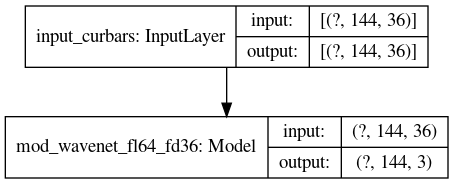

In [49]:
keras.utils.plot_model(model_no_f, 'model_no_f.png', show_shapes=True)

In [44]:
ds_train = tf.data.Dataset.zip((ds_curbars, ds_label)).shuffle(128, reshuffle_each_iteration=True).prefetch(tf.data.experimental.AUTOTUNE)
ds_valid = tf.data.Dataset.zip((ds_curbars_valid, ds_label_valid)).prefetch(tf.data.experimental.AUTOTUNE)

In [161]:
#optimizer = keras.optimizers.Adam(learning_rate=0.001)
#model_no_f.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
#checkpoint_cb = keras.callbacks.ModelCheckpoint("model_wn_no_f_b.h5", save_best_only=True)

#history = model_no_f.fit(ds_train, epochs=25,
#                       validation_data=ds_valid,
#                       callbacks=[checkpoint_cb])

Epoch 1/25
3500/3500 [==============================] - 206s 59ms/step - loss: 9.9472e-04 - mae: 0.0139 - val_loss: 1.8738e-05 - val_mae: 0.0042
Epoch 2/25
3500/3500 [==============================] - 196s 56ms/step - loss: 7.1254e-05 - mae: 0.0056 - val_loss: 6.6615e-06 - val_mae: 0.0026
Epoch 3/25
3500/3500 [==============================] - 194s 56ms/step - loss: 4.8545e-05 - mae: 0.0054 - val_loss: 6.8264e-06 - val_mae: 0.0023
Epoch 4/25
3500/3500 [==============================] - 196s 56ms/step - loss: 2.5057e-05 - mae: 0.0044 - val_loss: 9.9226e-06 - val_mae: 0.0034
Epoch 5/25
3500/3500 [==============================] - 196s 56ms/step - loss: 4.0205e-05 - mae: 0.0044 - val_loss: 2.5743e-06 - val_mae: 0.0013
Epoch 6/25
3500/3500 [==============================] - 194s 55ms/step - loss: 1.9656e-05 - mae: 0.0038 - val_loss: 6.9021e-06 - val_mae: 0.0028
Epoch 7/25
3500/3500 [==============================] - 198s 57ms/step - loss: 1.9963e-05 - mae: 0.0037 - val_loss: 2.1450e-06 - v

## Train Simple Model with economic news

In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
# dicrease dimension of economic data
i_nosprs = keras.layers.Conv2D(6, kernel_size=1, padding="valid", activation='relu')(input_nosparse)
i_nosprs = keras.layers.BatchNormalization()(i_nosprs)
i_nosprs = keras.layers.Conv2D(1, kernel_size=1, padding="valid", activation='relu')(i_nosprs)
i_nosprs = keras.layers.Reshape([train_size,70])(i_nosprs)

i_news = keras.layers.Concatenate()([i_nosprs, input_eventcur])
i_news = keras.layers.Conv1D(10, kernel_size=1, strides=1, padding='valid')(i_news)

model_news = keras.models.Model(inputs=[input_nosparse, input_eventcur], outputs=[i_news], name='model_news')

model_news.summary()

Model: "model_news"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 144, 70, 6)   18          input_nosparse[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 144, 70, 6)   24          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 144, 70, 1)   7           batch_normalization[0][0]        
_________________________________________________________________________________________

In [52]:
model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=96, n_outputs=3, feature_dim=46, name='mod_wavenet_fl96_fd46')

In [53]:
input_news = model_news([input_nosparse, input_eventcur])

input_wn = keras.layers.Concatenate(axis=-1)([input_curbars, input_news])

wave_out = model_wn(input_wn)

model_no_f_nosparse = keras.models.Model(inputs=[input_curbars, input_nosparse, input_eventcur], outputs=[wave_out])

model_no_f_nosparse.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
input_eventcur (InputLayer)     [(None, 144, 4)]     0                                            
__________________________________________________________________________________________________
input_curbars (InputLayer)      [(None, 144, 36)]    0                                            
__________________________________________________________________________________________________
model_news (Model)              (None, 144, 10)      799   

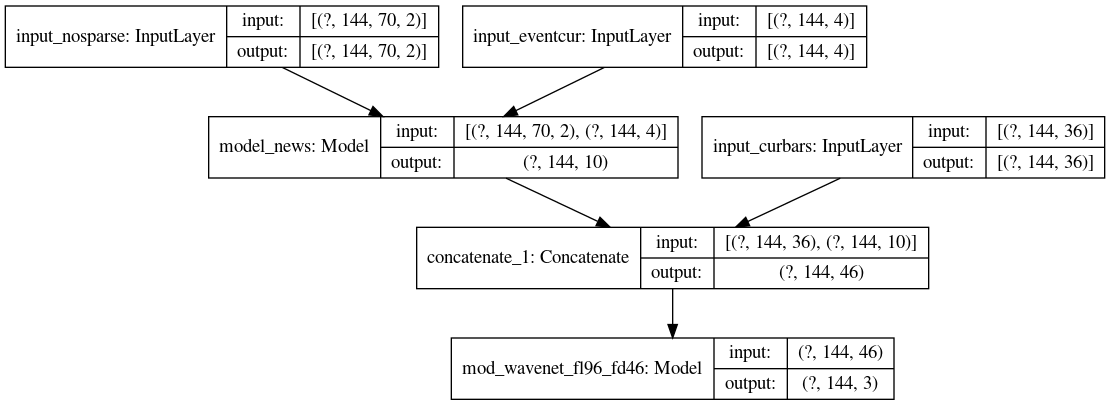

In [54]:
keras.utils.plot_model(model_no_f_nosparse, 'model_no_f_nosparse.png', show_shapes=True)

In [45]:
ds_train = tf.data.Dataset.zip(((ds_curbars, ds_nosparse, ds_eventcur), ds_label)).shuffle(128, reshuffle_each_iteration=True).prefetch(tf.data.experimental.AUTOTUNE)
ds_valid = tf.data.Dataset.zip(((ds_curbars_valid, ds_nosparse_valid, ds_eventcur_valid), ds_label_valid)).prefetch(tf.data.experimental.AUTOTUNE)

In [45]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_no_f_nosparse.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_nofut_nosparse.h5", save_best_only=True)

#history = model_no_f_nosparse.fit(ds_train, epochs=40,
#                       validation_data=ds_valid,
#                       callbacks=[checkpoint_cb])

Epoch 1/40
3500/3500 [==============================] - 414s 118ms/step - loss: 0.0016 - mae: 0.0207 - val_loss: 2.0989e-04 - val_mae: 0.0169
Epoch 2/40
3500/3500 [==============================] - 410s 117ms/step - loss: 1.0873e-04 - mae: 0.0090 - val_loss: 3.0817e-05 - val_mae: 0.0067
Epoch 3/40
3500/3500 [==============================] - 410s 117ms/step - loss: 5.3788e-05 - mae: 0.0060 - val_loss: 6.8537e-06 - val_mae: 0.0027
Epoch 4/40
3500/3500 [==============================] - 406s 116ms/step - loss: 3.4718e-05 - mae: 0.0050 - val_loss: 8.7216e-06 - val_mae: 0.0028
Epoch 5/40
3500/3500 [==============================] - 406s 116ms/step - loss: 3.4288e-05 - mae: 0.0050 - val_loss: 7.1162e-06 - val_mae: 0.0027
Epoch 6/40
3500/3500 [==============================] - 407s 116ms/step - loss: 2.9983e-05 - mae: 0.0042 - val_loss: 2.9439e-06 - val_mae: 0.0018
Epoch 7/40
3500/3500 [==============================] - 392s 112ms/step - loss: 1.9494e-05 - mae: 0.0036 - val_loss: 2.4329e-06 

In [ ]:
model_back = keras.models.load_model("model_nofut_nosparse.h5", custom_objects={'GatedActivationUnit' : GatedActivationUnit})

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_nofut_nosparse.h5", save_best_only=True)

#history = model_no_f_nosparse.fit(ds_train, epochs=40,
#                       validation_data=ds_valid,
#                       callbacks=[checkpoint_cb])

Epoch 1/40
3500/3500 [==============================] - 406s 116ms/step - loss: 5.2693e-06 - mae: 0.0016 - val_loss: 4.8368e-07 - val_mae: 7.6866e-04
Epoch 2/40
3500/3500 [==============================] - 408s 117ms/step - loss: 3.1530e-06 - mae: 0.0014 - val_loss: 2.5354e-07 - val_mae: 5.1345e-04
Epoch 3/40
3500/3500 [==============================] - 408s 116ms/step - loss: 3.3944e-06 - mae: 0.0013 - val_loss: 3.0894e-07 - val_mae: 6.1697e-04
Epoch 4/40
3500/3500 [==============================] - 406s 116ms/step - loss: 4.0766e-06 - mae: 0.0015 - val_loss: 3.7216e-07 - val_mae: 7.2735e-04
Epoch 5/40
3500/3500 [==============================] - 391s 112ms/step - loss: 2.8135e-06 - mae: 0.0013 - val_loss: 3.5234e-07 - val_mae: 6.5486e-04
Epoch 6/40
3500/3500 [==============================] - 413s 118ms/step - loss: 7.9496e-06 - mae: 0.0018 - val_loss: 7.7137e-07 - val_mae: 9.3843e-04
Epoch 7/40
3500/3500 [==============================] - 410s 117ms/step - loss: 3.7275e-06 - mae: 0.

# Evaluate model

In [44]:
model_direct = keras.models.load_model("model_nofut_nosparse.h5", custom_objects={'GatedActivationUnit' : GatedActivationUnit})

In [47]:
model_direct.evaluate(ds_valid)

   1163/Unknown - 92s 79ms/step - loss: 8.4465e-08 - mae: 2.3895e-04

[8.446481664240753e-08, 0.00023895457]

## Train Model with Returns and Relu output

In [44]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
def direction_acc(y_true, y_pred):
    return tf.where(tf.math.greater((y_true[:,-1,:] * y_pred[:,-1,:]), 0.0), 1.0, 0.0)
def direction_inacc(y_true, y_pred):
    return tf.where(tf.math.less((y_true[:,-1,:] * y_pred[:,-1,:]), 0.0), 1.0, 0.0)

def true_zero(y_true, y_pred):
    return tf.where(tf.math.equal(y_true[:,-1,:], 0.0), 1.0, 0.0)
def pred_zero(y_true, y_pred):
    return tf.where(tf.math.equal(y_pred[:,-1,:], 0.0), 1.0, 0.0)

def direction_acc_pos(y_true, y_pred):
    return tf.where(
                    tf.math.logical_and(tf.math.greater((y_true[:,-1,:] * y_pred[:,-1,:]), 0.0), 
                                        tf.math.greater(y_true[:,-1,:], 0.0)),
                    1.0, 0.0)

def direction_acc_neg(y_true, y_pred):
    return tf.where(
                    tf.math.logical_and(tf.math.greater((y_true[:,-1,:] * y_pred[:,-1,:]), 0.0), 
                                        tf.math.less(y_true[:,-1,:], 0.0)),
                    1.0, 0.0)

def direction_inacc_pos(y_true, y_pred):
    return tf.where(
                    tf.math.logical_and(tf.math.less((y_true[:,-1,:] * y_pred[:,-1,:]), 0.0), 
                                        tf.math.greater(y_true[:,-1,:], 0.0)),
                    1.0, 0.0)

def direction_inacc_neg(y_true, y_pred):
    return tf.where(
                    tf.math.logical_and(tf.math.less((y_true[:,-1,:] * y_pred[:,-1,:]), 0.0), 
                                        tf.math.less(y_true[:,-1,:], 0.0)),
                    1.0, 0.0)

In [46]:
ds_train = tf.data.Dataset.zip(((ds_curbars, ds_nosparse, ds_eventcur), ds_label_return)).shuffle(128, reshuffle_each_iteration=True).prefetch(tf.data.experimental.AUTOTUNE)
ds_valid = tf.data.Dataset.zip(((ds_curbars_valid, ds_nosparse_valid, ds_eventcur_valid), ds_label_return_valid)).prefetch(tf.data.experimental.AUTOTUNE)

In [141]:
# dicrease dimension of economic data
i_nosprs = keras.layers.Conv2D(6, kernel_size=1, padding="valid", activation='relu')(input_nosparse)
i_nosprs = keras.layers.BatchNormalization()(i_nosprs)
i_nosprs = keras.layers.Conv2D(1, kernel_size=1, padding="valid", activation='relu')(i_nosprs)
i_nosprs = keras.layers.Reshape([train_size,70])(i_nosprs)

i_news = keras.layers.Concatenate()([i_nosprs, input_eventcur])
i_news = keras.layers.Conv1D(10, kernel_size=1, strides=1, padding='valid')(i_news)

model_news = keras.models.Model(inputs=[input_nosparse, input_eventcur], outputs=[i_news], name='model_news')

model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=96, n_outputs=3, feature_dim=46, name='mod_wavenet_fl96_fd46')

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0


In [142]:
input_news = model_news([input_nosparse, input_eventcur])

input_wn = keras.layers.Concatenate(axis=-1)([input_curbars, input_news])

wave_out = model_wn(input_wn)

model_ret_pos = keras.models.Model(inputs=[input_curbars, input_nosparse, input_eventcur], outputs=[wave_out])

model_ret_pos.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
input_eventcur (InputLayer)     [(None, 144, 4)]     0                                            
__________________________________________________________________________________________________
input_curbars (InputLayer)      [(None, 144, 36)]    0                                            
__________________________________________________________________________________________________
model_news (Model)              (None, 144, 10)      799   

In [144]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ret_pos.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae", direction_acc, direction_inacc, pred_zero])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_return_pos.h5", save_best_only=True)

history = model_ret_pos.fit(ds_train, epochs=5,
                       validation_data=ds_valid,
                       callbacks=[checkpoint_cb])

Epoch 1/5
3500/3500 [==============================] - 398s 114ms/step - loss: 0.1823 - mae: 0.4400 - direction_acc: 0.3195 - direction_inacc: 0.1162 - pred_zero: 0.5643 - val_loss: 0.1097 - val_mae: 0.3199 - val_direction_acc: 0.3519 - val_direction_inacc: 0.1422 - val_pred_zero: 0.5058
Epoch 2/5
3500/3500 [==============================] - 393s 112ms/step - loss: 0.1790 - mae: 0.4347 - direction_acc: 0.3390 - direction_inacc: 0.1219 - pred_zero: 0.5391 - val_loss: 0.1096 - val_mae: 0.3191 - val_direction_acc: 0.3337 - val_direction_inacc: 0.1240 - val_pred_zero: 0.5423
Epoch 3/5
3500/3500 [==============================] - 392s 112ms/step - loss: 0.1772 - mae: 0.4322 - direction_acc: 0.3353 - direction_inacc: 0.1165 - pred_zero: 0.5481 - val_loss: 0.1097 - val_mae: 0.3189 - val_direction_acc: 0.3225 - val_direction_inacc: 0.1167 - val_pred_zero: 0.5608
Epoch 4/5
3500/3500 [==============================] - 395s 113ms/step - loss: 0.1760 - mae: 0.4306 - direction_acc: 0.3282 - directi

## Train Model with Returns and negative Relu output

In [121]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [122]:
# dicrease dimension of economic data
i_nosprs = keras.layers.Conv2D(6, kernel_size=1, padding="valid", activation='relu')(input_nosparse)
i_nosprs = keras.layers.BatchNormalization()(i_nosprs)
i_nosprs = keras.layers.Conv2D(1, kernel_size=1, padding="valid", activation='relu')(i_nosprs)
i_nosprs = keras.layers.Reshape([train_size,70])(i_nosprs)

i_news = keras.layers.Concatenate()([i_nosprs, input_eventcur])
i_news = keras.layers.Conv1D(10, kernel_size=1, strides=1, padding='valid')(i_news)

model_news = keras.models.Model(inputs=[input_nosparse, input_eventcur], outputs=[i_news], name='model_news')

model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=96, n_outputs=3, feature_dim=46, name='mod_wavenet_fl96_fd46', last_activation=None)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0


In [123]:
input_news = model_news([input_nosparse, input_eventcur])

input_wn = keras.layers.Concatenate(axis=-1)([input_curbars, input_news])

wave_out = model_wn(input_wn)

out = keras.layers.Activation('relu')(wave_out)

out = keras.layers.Lambda(lambda x: x * -1.0)(out)

model_ret_neg = keras.models.Model(inputs=[input_curbars, input_nosparse, input_eventcur], outputs=[out])

model_ret_neg.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
input_eventcur (InputLayer)     [(None, 144, 4)]     0                                            
__________________________________________________________________________________________________
input_curbars (InputLayer)      [(None, 144, 36)]    0                                            
__________________________________________________________________________________________________
model_news (Model)              (None, 144, 10)      799   

In [124]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ret_neg.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae", direction_acc, direction_inacc, pred_zero])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_return_neg.h5", save_best_only=True)

history = model_ret_neg.fit(ds_train, epochs=5,
                       validation_data=ds_valid,
                       callbacks=[checkpoint_cb])

Epoch 1/5
3500/3500 [==============================] - 398s 114ms/step - loss: 0.1842 - mae: 0.4422 - direction_acc: 0.3133 - direction_inacc: 0.1154 - pred_zero: 0.5713 - val_loss: 0.1096 - val_mae: 0.3194 - val_direction_acc: 0.3149 - val_direction_inacc: 0.1129 - val_pred_zero: 0.5722
Epoch 2/5
3500/3500 [==============================] - 394s 112ms/step - loss: 0.1787 - mae: 0.4340 - direction_acc: 0.3407 - direction_inacc: 0.1215 - pred_zero: 0.5378 - val_loss: 0.1094 - val_mae: 0.3187 - val_direction_acc: 0.3025 - val_direction_inacc: 0.0997 - val_pred_zero: 0.5978
Epoch 3/5
3500/3500 [==============================] - 395s 113ms/step - loss: 0.1772 - mae: 0.4321 - direction_acc: 0.3377 - direction_inacc: 0.1171 - pred_zero: 0.5452 - val_loss: 0.1101 - val_mae: 0.3196 - val_direction_acc: 0.3422 - val_direction_inacc: 0.1343 - val_pred_zero: 0.5235
Epoch 4/5
3500/3500 [==============================] - 400s 114ms/step - loss: 0.1760 - mae: 0.4305 - direction_acc: 0.3328 - directi

## Train Model with Returns and No-Activation output

In [125]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [126]:
# dicrease dimension of economic data
i_nosprs = keras.layers.Conv2D(6, kernel_size=1, padding="valid", activation='relu')(input_nosparse)
i_nosprs = keras.layers.BatchNormalization()(i_nosprs)
i_nosprs = keras.layers.Conv2D(1, kernel_size=1, padding="valid", activation='relu')(i_nosprs)
i_nosprs = keras.layers.Reshape([train_size,70])(i_nosprs)

i_news = keras.layers.Concatenate()([i_nosprs, input_eventcur])
i_news = keras.layers.Conv1D(10, kernel_size=1, strides=1, padding='valid')(i_news)

model_news = keras.models.Model(inputs=[input_nosparse, input_eventcur], outputs=[i_news], name='model_news')

model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=96, n_outputs=3, feature_dim=46, name='mod_wavenet_fl96_fd46', last_activation=None)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0


In [127]:
input_news = model_news([input_nosparse, input_eventcur])

input_wn = keras.layers.Concatenate(axis=-1)([input_curbars, input_news])

wave_out = model_wn(input_wn)

model_ret_noact = keras.models.Model(inputs=[input_curbars, input_nosparse, input_eventcur], outputs=[wave_out])

model_ret_noact.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
input_eventcur (InputLayer)     [(None, 144, 4)]     0                                            
__________________________________________________________________________________________________
input_curbars (InputLayer)      [(None, 144, 36)]    0                                            
__________________________________________________________________________________________________
model_news (Model)              (None, 144, 10)      799   

In [128]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ret_noact.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae", 
                                                                                 direction_acc, 
                                                                                 direction_inacc, 
                                                                                 pred_zero, 
                                                                                 direction_acc_pos, 
                                                                                 direction_inacc_pos,
                                                                                 direction_acc_neg,
                                                                                 direction_inacc_neg,])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_ret_noact.h5", save_best_only=True)

history = model_ret_noact.fit(ds_train, epochs=5,
                       validation_data=ds_valid,
                       callbacks=[checkpoint_cb])

Epoch 1/5
3500/3500 [==============================] - 403s 115ms/step - loss: 0.1431 - mae: 0.3818 - direction_acc: 0.7165 - direction_inacc: 0.2834 - pred_zero: 0.0000e+00 - direction_acc_pos: 0.3580 - direction_inacc_pos: 0.1410 - direction_acc_neg: 0.3585 - direction_inacc_neg: 0.1425 - val_loss: 0.0892 - val_mae: 0.2845 - val_direction_acc: 0.7075 - val_direction_inacc: 0.2925 - val_pred_zero: 0.0000e+00 - val_direction_acc_pos: 0.3152 - val_direction_inacc_pos: 0.1849 - val_direction_acc_neg: 0.3923 - val_direction_inacc_neg: 0.1075
Epoch 2/5
3500/3500 [==============================] - 394s 113ms/step - loss: 0.1385 - mae: 0.3747 - direction_acc: 0.7237 - direction_inacc: 0.2763 - pred_zero: 0.0000e+00 - direction_acc_pos: 0.3615 - direction_inacc_pos: 0.1375 - direction_acc_neg: 0.3622 - direction_inacc_neg: 0.1388 - val_loss: 0.0888 - val_mae: 0.2835 - val_direction_acc: 0.7075 - val_direction_inacc: 0.2925 - val_pred_zero: 0.0000e+00 - val_direction_acc_pos: 0.3865 - val_dire

## Evaluate Return models

In [47]:
model_ret_pos = keras.models.load_model("model_return_pos.h5", custom_objects={'GatedActivationUnit' : GatedActivationUnit,
                                                                               'direction_acc' : direction_acc,
                                                                               'direction_inacc' : direction_inacc,
                                                                                'pred_zero' : pred_zero})

In [48]:
model_ret_neg = keras.models.load_model("model_return_neg.h5", custom_objects={'GatedActivationUnit' : GatedActivationUnit,
                                                                               'direction_acc' : direction_acc,
                                                                               'direction_inacc' : direction_inacc,
                                                                               'pred_zero' : pred_zero})

In [49]:
model_ret_noact = keras.models.load_model("model_ret_noact.h5", custom_objects={'GatedActivationUnit' : GatedActivationUnit,
                                                                                 'direction_acc' : direction_acc,
                                                                                 'direction_inacc' : direction_inacc,
                                                                                 'pred_zero' : pred_zero,
                                                                                 'direction_acc_pos' : direction_acc_pos,
                                                                                 'direction_acc_neg' : direction_acc_neg,
                                                                                 'direction_inacc_pos' : direction_inacc_pos,
                                                                                 'direction_inacc_neg' : direction_inacc_neg})

In [50]:
print(model_ret_pos.evaluate(ds_valid))
print(model_ret_neg.evaluate(ds_valid))
print(model_ret_noact.evaluate(ds_valid))

   1163/Unknown - 92s 79ms/step - loss: 0.1096 - mae: 0.3191 - direction_acc: 0.3337 - direction_inacc: 0.1240 - pred_zero: 0.5423[0.10958664581061102, 0.31914082, 0.333714, 0.124032676, 0.5422533]
   1163/Unknown - 89s 76ms/step - loss: 0.1094 - mae: 0.3187 - direction_acc: 0.3025 - direction_inacc: 0.0997 - pred_zero: 0.5978[0.10943622453104598, 0.31869307, 0.30252668, 0.09966592, 0.5978074]
   1163/Unknown - 89s 77ms/step - loss: 0.0888 - mae: 0.2835 - direction_acc: 0.7075 - direction_inacc: 0.2925 - pred_zero: 0.0000e+00 - direction_acc_pos: 0.3865 - direction_inacc_pos: 0.1137 - direction_acc_neg: 0.3210 - direction_inacc_neg: 0.1788[0.0888115835383291, 0.283519, 0.70749587, 0.29249516, 0.0, 0.38649148, 0.113669746, 0.32100442, 0.17882541]


In [54]:
pred_pos = model_ret_pos.predict(ds_valid)
pred_neg = model_ret_neg.predict(ds_valid)
pred_noact = model_ret_noact.predict(ds_valid)

In [61]:
pred_pos = pred_pos[:, -1, :]
pred_neg = pred_neg[:, -1, :]
pred_noact = pred_noact[:, -1, :]

In [62]:
pd.DataFrame(pred_pos).to_csv('pred_pos.csv')
pd.DataFrame(pred_neg).to_csv('pred_neg.csv')
pd.DataFrame(pred_noact).to_csv('pred_noact.csv')

In [92]:
pred_pos = pd.read_csv('pred_pos.csv', header=0, names = ['ix', 'c_eur', 'c_gbp', 'c_jpy']).iloc[:,1:]
pred_neg = pd.read_csv('pred_neg.csv',header=0, names = ['ix', 'c_eur', 'c_gbp', 'c_jpy']).iloc[:,1:]
pred_noact = pd.read_csv('pred_noact.csv',header=0, names = ['ix', 'c_eur', 'c_gbp', 'c_jpy']).iloc[:,1:]

In [93]:
pred_pos

,c_eur,c_gbp,c_jpy
0,0.000000,0.000000,0.658592
1,0.164198,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.221832,0.202434,0.000000
...,...,...,...
74427,0.166318,0.069800,0.336353
74428,0.129790,1.166341,0.000000
74429,0.000000,0.235035,0.637633
74430,0.039457,0.000000,0.231163


In [94]:
df_label_return_valid

,c_eur,c_gbp,c_jpy
,mean_log_r,mean_log_r,mean_log_r
ctime,,,
2019-01-01 23:00:00,-0.204493,-0.463093,-1.851031
2019-01-01 23:05:00,0.211720,-0.682056,-0.042275
2019-01-01 23:10:00,0.119111,0.078771,-0.308178
2019-01-01 23:15:00,0.004277,-0.037280,-0.597788
2019-01-01 23:20:00,0.124356,-0.145055,0.165415
...,...,...,...
2019-12-31 21:35:00,-0.048386,0.197334,-0.022041
2019-12-31 21:40:00,-0.000601,1.112390,0.169539


In [95]:
df_label_test = df_label_return_valid.iloc[144:]

In [96]:
df_label_test = df_label_test[:74432]

In [97]:
df_label_test.columns = df_label_test.columns.droplevel(1)

In [98]:
df_label_test.reset_index(inplace = True)
df_label_test = df_label_test.drop(columns=['ctime'])
df_label_test

,c_eur,c_gbp,c_jpy
0,-0.152821,-0.202791,-0.179070
1,-0.733175,-0.458837,-0.894827
2,-1.315369,-0.539606,-0.509547
3,-0.236286,-0.354351,-0.556738
4,1.568475,0.805176,0.521231
...,...,...,...
74427,0.524363,1.498890,0.245461
74428,-0.023553,0.528620,-0.251353
74429,-0.366690,-1.429068,0.418885
74430,-0.287221,-0.649645,-0.137921


In [99]:
# test if we are ok:
print(df_label_test.sub(pred_pos).abs().mean().mean())
print(df_label_test.sub(pred_neg).abs().mean().mean())
print(df_label_test.sub(pred_noact).abs().mean().mean())
# ok, same as from model

0.31903169787425056
0.3186375348751795
0.28351312171915916


In [100]:
pred_double_act = pd.concat([pred_pos, pred_neg, pred_noact, df_label_test], axis=1, keys=['pos', 'neg', 'noact', 'label'], sort=False)

In [101]:
pred_double_act

pos                           neg                         noact  \
          c_eur     c_gbp     c_jpy     c_eur     c_gbp     c_jpy     c_eur   
0      0.000000  0.000000  0.658592 -0.275718 -0.000000 -0.000000 -0.011522   
1      0.164198  0.000000  0.000000 -0.000000 -0.104623 -0.647641 -0.184416   
2      0.000000  0.000000  0.000000 -0.848652 -0.000000 -0.307110 -0.931917   
3      0.000000  0.000000  0.000000 -0.720256 -0.654472 -0.271369 -0.719075   
4      0.221832  0.202434  0.000000 -0.000000 -0.000000 -0.270350  0.662746   
...         ...       ...       ...       ...       ...       ...       ...   
74427  0.166318  0.069800  0.336353 -0.000000 -0.000000 -0.000000 -0.063328   
74428  0.129790  1.166341  0.000000 -0.000000 -0.000000 -0.042822  0.418199   
74429  0.000000  0.235035  0.637633 -0.029545 -0.000000 -0.000000  0.038537   
74430  0.039457  0.000000  0.231163 -0.011902 -0.179632 -0.000000  0.115993   
74431  0.000000  0.000000  0.000000 -0.237564 -0.174447 -0.000000 -0.128946   

                              label                      
          c_gbp     c_jpy     c_eur     c_gbp     c_jpy  
0      0.033756  0.859337 -0.152821 -0.202791 -0.179070  
1     -0.352459 -0.597647 -0.733175 -0.458837 -0.894827  
2     -0.513463 -0.426679 -1.315369 -0.539606 -0.509547  
3     -0.606441 -0.029457 -0.236286 -0.354351 -0.556738  
4      0.375412 -0.283819  1.568475  0.805176  0.521231  
...         ...       ...       ...       ...       ...  
74427 -0.109615 -0.010298  0.524363  1.498890  0.245461  
74428  0.857505  0.208144 -0.023553  0.528620 -0.251353  
74429  0.343883  0.279920 -0.366690 -1.429068  0.418885  
74430 -0.079356  0.183840 -0.287221 -0.649645 -0.137921  
74431 -0.094197 -0.076094 -0.463287 -0.039784 -0.060899  

[74432 rows x 12 columns]

In [102]:
def prediction_filter(row):
    if(row[0] != 0.0) and (row[1] != 0.0):
        val = 0.0
    elif(row[0] > 0):
        val = row[0]
    else:
        val = row[1]   
    return val

In [103]:
pred_double_act[('dbl', 'c_eur')] = pred_double_act[[('pos', 'c_eur'), ('neg', 'c_eur')]].apply(prediction_filter, axis=1)
pred_double_act[('dbl', 'c_gbp')] = pred_double_act[[('pos', 'c_gbp'), ('neg', 'c_gbp')]].apply(prediction_filter, axis=1)
pred_double_act[('dbl', 'c_jpy')] = pred_double_act[[('pos', 'c_jpy'), ('neg', 'c_jpy')]].apply(prediction_filter, axis=1)

In [104]:
pred_double_act

pos                           neg                         noact  \
          c_eur     c_gbp     c_jpy     c_eur     c_gbp     c_jpy     c_eur   
0      0.000000  0.000000  0.658592 -0.275718 -0.000000 -0.000000 -0.011522   
1      0.164198  0.000000  0.000000 -0.000000 -0.104623 -0.647641 -0.184416   
2      0.000000  0.000000  0.000000 -0.848652 -0.000000 -0.307110 -0.931917   
3      0.000000  0.000000  0.000000 -0.720256 -0.654472 -0.271369 -0.719075   
4      0.221832  0.202434  0.000000 -0.000000 -0.000000 -0.270350  0.662746   
...         ...       ...       ...       ...       ...       ...       ...   
74427  0.166318  0.069800  0.336353 -0.000000 -0.000000 -0.000000 -0.063328   
74428  0.129790  1.166341  0.000000 -0.000000 -0.000000 -0.042822  0.418199   
74429  0.000000  0.235035  0.637633 -0.029545 -0.000000 -0.000000  0.038537   
74430  0.039457  0.000000  0.231163 -0.011902 -0.179632 -0.000000  0.115993   
74431  0.000000  0.000000  0.000000 -0.237564 -0.174447 -0.000000 -0.128946   

                              label                           dbl            \
          c_gbp     c_jpy     c_eur     c_gbp     c_jpy     c_eur     c_gbp   
0      0.033756  0.859337 -0.152821 -0.202791 -0.179070 -0.275718 -0.000000   
1     -0.352459 -0.597647 -0.733175 -0.458837 -0.894827  0.164198 -0.104623   
2     -0.513463 -0.426679 -1.315369 -0.539606 -0.509547 -0.848652 -0.000000   
3     -0.606441 -0.029457 -0.236286 -0.354351 -0.556738 -0.720256 -0.654472   
4      0.375412 -0.283819  1.568475  0.805176  0.521231  0.221832  0.202434   
...         ...       ...       ...       ...       ...       ...       ...   
74427 -0.109615 -0.010298  0.524363  1.498890  0.245461  0.166318  0.069800   
74428  0.857505  0.208144 -0.023553  0.528620 -0.251353  0.129790  1.166341   
74429  0.343883  0.279920 -0.366690 -1.429068  0.418885 -0.029545  0.235035   
74430 -0.079356  0.183840 -0.287221 -0.649645 -0.137921  0.000000 -0.179632   
74431 -0.094197 -0.076094 -0.463287 -0.039784 -0.060899 -0.237564 -0.174447   

                 
          c_jpy  
0      0.658592  
1     -0.647641  
2     -0.307110  
3     -0.271369  
4     -0.270350  
...         ...  
74427  0.336353  
74428 -0.042822  
74429  0.637633  
74430  0.231163  
74431 -0.000000  

[74432 rows x 15 columns]

In [105]:
print(df_label_test.sub(pred_double_act['dbl']).abs().mean().mean())

0.28218349869109094


In [108]:
acc_pos = (df_label_test.multiply(pred_double_act['pos'])>0.0).mean().mean()
acc_neg = (df_label_test.multiply(pred_double_act['neg'])>0.0).mean().mean()
acc_noact = (df_label_test.multiply(pred_double_act['noact'])>0.0).mean().mean()
acc_dbl = (df_label_test.multiply(pred_double_act['dbl'])>0.0).mean().mean()

In [109]:
inacc_pos = (df_label_test.multiply(pred_double_act['pos'])<0.0).mean().mean()
inacc_neg = (df_label_test.multiply(pred_double_act['neg'])<0.0).mean().mean()
inacc_noact = (df_label_test.multiply(pred_double_act['noact'])<0.0).mean().mean()
inacc_dbl = (df_label_test.multiply(pred_double_act['dbl'])<0.0).mean().mean()

In [110]:
print(acc_pos)
print(acc_neg)
print(acc_noact)
print(acc_dbl)

0.3337139939810834
0.30252669102894814
0.7074958799082832
0.6155954428202924


In [111]:
print(inacc_pos)
print(inacc_neg)
print(inacc_noact)
print(inacc_dbl)

0.12403267411865863
0.0996659143020923
0.2924951633705933
0.20305334623101176


In [112]:
print(acc_pos/inacc_pos)
print(acc_neg/inacc_neg)
print(acc_noact/inacc_noact)
print(acc_dbl/inacc_dbl)

2.690532928942808
3.035407773534037
2.4188293295362335
3.031693169537505


## Probabilistic Wavenet

In [51]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
ds_train = tf.data.Dataset.zip(((ds_curbars, ds_nosparse, ds_eventcur),
                                (ds_label_return_eur, ds_label_return_gbp, ds_label_return_jpy))).shuffle(128, reshuffle_each_iteration=True).prefetch(tf.data.experimental.AUTOTUNE).take(2)
ds_valid = tf.data.Dataset.zip(((ds_curbars_valid, ds_nosparse_valid, ds_eventcur_valid), 
                                (ds_label_return_eur_valid, ds_label_return_gbp_valid, ds_label_return_jpy_valid))).prefetch(tf.data.experimental.AUTOTUNE).take(2)

In [56]:
# dicrease dimension of economic data
i_nosprs = keras.layers.Conv2D(6, kernel_size=1, padding="valid", activation='relu')(input_nosparse)
i_nosprs = keras.layers.BatchNormalization()(i_nosprs)
i_nosprs = keras.layers.Conv2D(1, kernel_size=1, padding="valid", activation='relu')(i_nosprs)
i_nosprs = keras.layers.Reshape([train_size,70])(i_nosprs)

i_news = keras.layers.Concatenate()([i_nosprs, input_eventcur])
i_news = keras.layers.Conv1D(10, kernel_size=1, strides=1, padding='valid')(i_news)

model_news = keras.models.Model(inputs=[input_nosparse, input_eventcur], outputs=[i_news], name='model_news')

In [57]:
# define the output distribution parameters
num_components = 2   # Number of components in the mixture (2 would be optional, but most of the time we don't know)
event_shape = [1]  # shape of the target
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)   # calculate the required input size for the mixture layer
print(params_size)

6


In [58]:
model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=96, n_outputs=params_size*3, feature_dim=46, name='mod_wavenet_fl96_fd46', last_activation=None)
model_wn.summary()

Model: "mod_wavenet_fl96_fd46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 46)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 144, 96)      8928        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 144, 192)     37056       conv1d_1[0][0]                   
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, 144, 96)      0           conv1d_2[0][0]                   
______________________________________________________________________________

In [65]:
input_news = model_news([input_nosparse, input_eventcur])

input_wn = keras.layers.Concatenate(axis=-1)([input_curbars, input_news])

wave_out = model_wn(input_wn)

dist_out_0 = tfp.layers.MixtureNormal(num_components, event_shape)(wave_out[..., 0:6])
dist_out_1 = tfp.layers.MixtureNormal(num_components, event_shape)(wave_out[..., 6:12])
dist_out_2 = tfp.layers.MixtureNormal(num_components, event_shape)(wave_out[..., 12:])

model_ret_prob = keras.models.Model(inputs=[input_curbars, input_nosparse, input_eventcur], outputs=[dist_out_0, dist_out_1, dist_out_2])

model_ret_prob.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
input_eventcur (InputLayer)     [(None, 144, 4)]     0                                            
__________________________________________________________________________________________________
input_curbars (InputLayer)      [(None, 144, 36)]    0                                            
__________________________________________________________________________________________________
model_news (Model)              (None, 144, 10)      799 

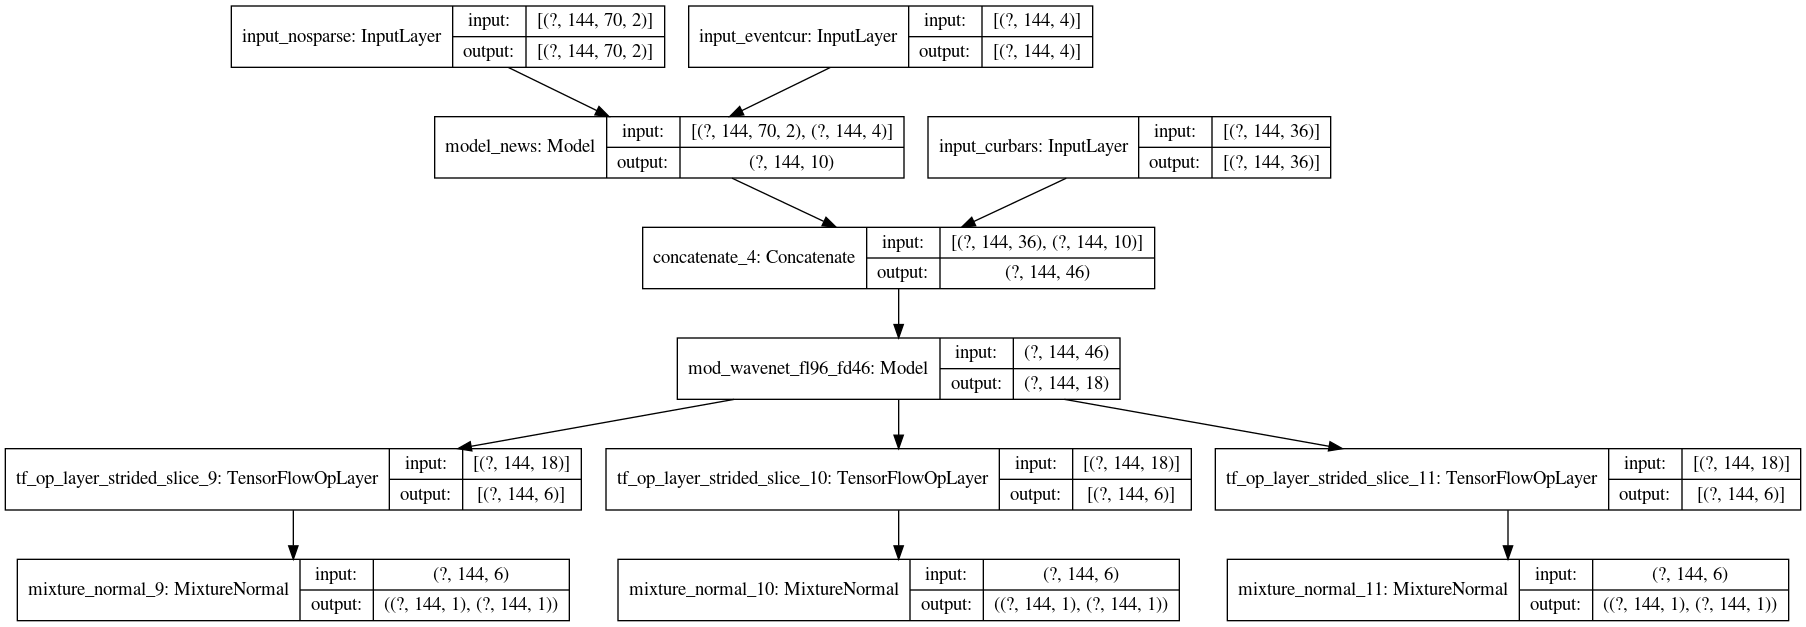

In [66]:
keras.utils.plot_model(model_ret_prob, "model_ret_prob.png", show_shapes=True)

In [67]:
# loss function for distributions
def negloglik(y, rv_y):
    return -rv_y.log_prob(y)

In [68]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ret_prob.compile(loss=negloglik, optimizer=optimizer)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_ret_prob.h5", save_best_only=True)

history = model_ret_prob.fit(ds_train, 
                             validation_data=ds_valid,
                             epochs=5,
                             callbacks=[checkpoint_cb])

Epoch 1/5
2/2 [==============================] - 25s 12s/step - loss: 6.5457 - mixture_normal_9_loss: 1.9012 - mixture_normal_10_loss: 1.7995 - mixture_normal_11_loss: 2.8450 - val_loss: 3.6947 - val_mixture_normal_9_loss: 1.2043 - val_mixture_normal_10_loss: 1.2848 - val_mixture_normal_11_loss: 1.2055
Epoch 2/5
2/2 [==============================] - 16s 8s/step - loss: 4.2202 - mixture_normal_9_loss: 1.4342 - mixture_normal_10_loss: 1.2131 - mixture_normal_11_loss: 1.5729 - val_loss: 3.7229 - val_mixture_normal_9_loss: 1.2024 - val_mixture_normal_10_loss: 1.2653 - val_mixture_normal_11_loss: 1.2552
Epoch 3/5
2/2 [==============================] - 15s 8s/step - loss: 3.5366 - mixture_normal_9_loss: 1.1273 - mixture_normal_10_loss: 1.1468 - mixture_normal_11_loss: 1.2624 - val_loss: 3.6994 - val_mixture_normal_9_loss: 1.1684 - val_mixture_normal_10_loss: 1.2720 - val_mixture_normal_11_loss: 1.2591
Epoch 4/5
2/2 [==============================] - 16s 8s/step - loss: 4.6004 - mixture_norm

In [69]:
model_ret_prob = keras.models.load_model("model_ret_prob.h5", custom_objects={'GatedActivationUnit' : GatedActivationUnit, 'negloglik': negloglik}, compile=False)

In [70]:
# list of batched distributions
yhat = []
for i, next_element in enumerate(ds_valid):   
    yhat.append(model_ret_prob(next_element))

In [78]:
yhat[0][2]

<tfp.distributions.MixtureSameFamily 'model_2_mixture_normal_11_MixtureSameFamily_MixtureSameFamily' batch_shape=[64, 144] event_shape=[1] dtype=float32>

In [79]:
# check only jpy
weights = yhat[0][2].submodules[1].probs_parameter().numpy()[:,-1]
means = np.squeeze(yhat[0][2].submodules[2].mean().numpy()[:,-1])
devs = np.squeeze(yhat[0][2].submodules[2].stddev().numpy()[:,-1])

for i in range(1, len(yhat)):
    weights = np.concatenate((weights, yhat[i][2].submodules[1].probs_parameter().numpy()[:,-1]), axis=0)
    means = np.concatenate((means, np.squeeze(yhat[i][2].submodules[2].mean().numpy()[:,-1])), axis=0)
    devs = np.concatenate((devs, np.squeeze(yhat[i][2].submodules[2].stddev().numpy()[:,-1])), axis=0)

In [80]:
np.save('prob_weights', weights)
np.save('prob_means', means)
np.save('prob_devs', devs)

In [81]:
weights = np.load('prob_weights.npy')
means = np.load('prob_means.npy')
devs = np.load('prob_devs.npy')

In [82]:
weights.shape

(128, 2)

In [83]:
print(np.median(np.abs(means[:,0]-means[:,1])))

0.44731596


In [84]:
sorted_args = np.argsort(np.abs(means[:,0]-means[:,1]))

## The least volatile

In [85]:
print(np.abs(means[sorted_args[0],0]-means[sorted_args[0],1]))
print(means[sorted_args[0]])
print(devs[sorted_args[0]])
print(weights[sorted_args[0]])

0.01260137
[0.02857123 0.0411726 ]
[0.6460076 1.1051391]
[0.41406265 0.5859374 ]


## The most volatile

In [86]:
print(np.abs(means[sorted_args[-1],0]-means[sorted_args[-1],1]))
print(means[sorted_args[-1]])
print(devs[sorted_args[-1]])
print(weights[sorted_args[-1]])

1.0036162
[-0.388529   0.6150872]
[0.59745187 1.0530219 ]
[0.33758858 0.6624114 ]


In [87]:
# rebuild the distribution of the 6th step from the forecasted data
def mixture_builder(index):
    return tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights[index]),
        components_distribution=tfd.Normal(
            loc=means[index],       
            scale=devs[index]))

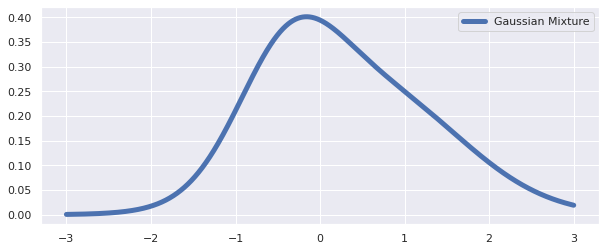

In [88]:
f = plt.figure(figsize=(10,4))
ax = plt.gca()

x = np.linspace(-3, 3, int(1e4), dtype=np.float32)
ax.plot(x, mixture_builder(sorted_args[-1]).prob(x).numpy(), lw=5, label="Gaussian Mixture")
_ = ax.legend()

## Wavenet with future

In [68]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
ds_train = tf.data.Dataset.zip(((ds_curbars, ds_nosparse, ds_eventcur, ds_future_b), ds_label_return)).shuffle(128, reshuffle_each_iteration=True).prefetch(tf.data.experimental.AUTOTUNE)
ds_valid = tf.data.Dataset.zip(((ds_curbars_valid, ds_nosparse_valid, ds_eventcur_valid, ds_future_b_valid), ds_label_return_valid)).prefetch(tf.data.experimental.AUTOTUNE)

In [70]:
# dicrease dimension of economic data
i_nosprs = keras.layers.Conv2D(6, kernel_size=1, padding="valid", activation='relu')(input_nosparse)
i_nosprs = keras.layers.BatchNormalization()(i_nosprs)
i_nosprs = keras.layers.Conv2D(1, kernel_size=1, padding="valid", activation='relu')(i_nosprs)
i_nosprs = keras.layers.Reshape([train_size,70])(i_nosprs)

i_news = keras.layers.Concatenate()([i_nosprs, input_eventcur, input_future_b])

i_news = keras.layers.Conv1D(15, kernel_size=1, strides=1, padding='valid')(i_news)

model_news = keras.models.Model(inputs=[input_nosparse, input_eventcur, input_future_b], outputs=[i_news], name='model_news')

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_future_b:0


In [71]:
# define the output distribution parameters
num_components = 2   # Number of components in the mixture (2 would be optional, but most of the time we don't know)
event_shape = 1   # shape of the target (10 steps)
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)   # calculate the required input size for the mixture layer
print(params_size)

6


In [72]:
model_wn = wavenet_model_setup(n_layers_per_block=4, n_blocks=2, n_filters=96, n_outputs=params_size, feature_dim=51, name='mod_wavenet_fl96_fd51', last_activation=None)

In [73]:
input_news = model_news([input_nosparse, input_eventcur, input_future_b])

input_wn = keras.layers.Concatenate(axis=-1)([input_curbars, input_news])

wave_out = model_wn(input_wn)

dist_out = tfp.layers.MixtureNormal(num_components, event_shape)(wave_out)

model_ret_prob_f = keras.models.Model(inputs=[input_curbars, input_nosparse, input_eventcur, input_future_b], outputs=[dist_out])

model_ret_prob_f.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_eventcur:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_future_b:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_nosparse (InputLayer)     [(None, 144, 70, 2)] 0                                            
__________________________________________________________________________________________________
input_eventcur (InputLayer)     [(None, 144, 4)]     0                                            
__________________________________________________________________________________________________
input_future_b (InputLayer)     [(None, 144, 74)]    0                                            
________________________

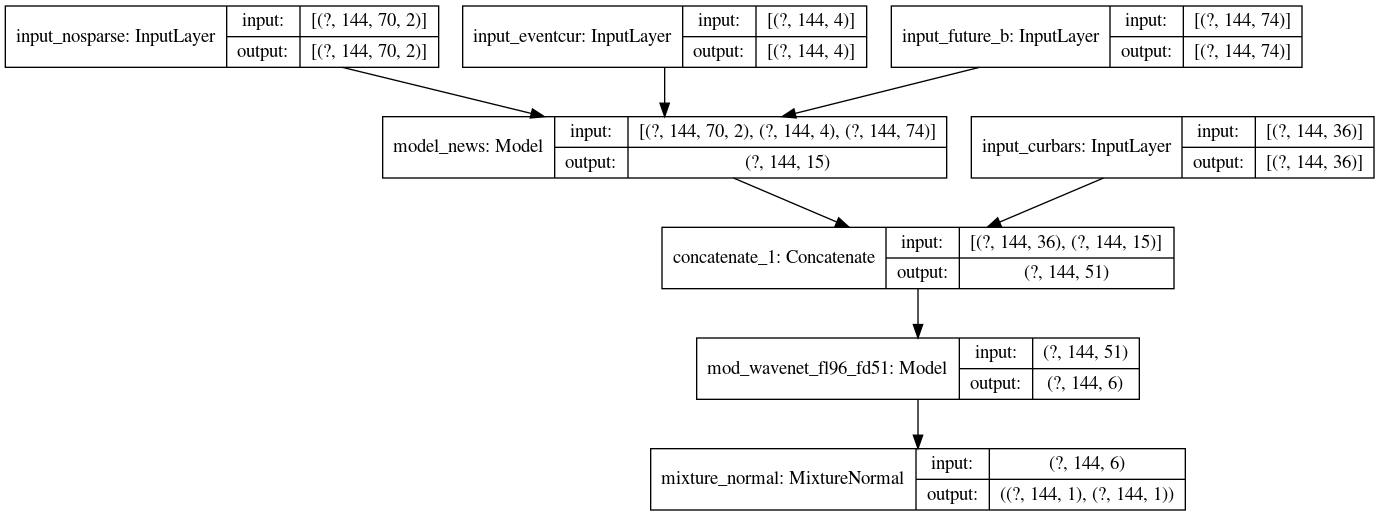

In [74]:
keras.utils.plot_model(model_ret_prob_f, "model_ret_prob_f.png", show_shapes=True)

In [75]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_ret_prob_f.compile(loss=negloglik, optimizer=optimizer)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_ret_prob_f.h5", save_best_only=True)

history = model_ret_prob_f.fit(ds_train, 
                             validation_data=ds_valid,
                             epochs=5,
                             callbacks=[checkpoint_cb])

Epoch 1/5
   1160/Unknown - 1434s 1s/step - loss: 2.9204WARNING:tensorflow:Can save best model only with val_loss available, skipping.
   1160/Unknown - 1434s 1s/step - loss: 2.9204

KeyboardInterrupt: 